In [6]:
from compton.Functions import *
from compton.Analysis import *
from positron.Dataloader import *
from positron.Analysis import *
import os
from sympy import symbols, Eq, latex
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import pandas as pd
import muon.Dataloader as dl
from muon.Analysis import *
from muon.Functions import *

,count
time (ns),
10,869
11,869
12,908
13,895
14,876
...,...
1019,25
1020,20
1021,27


Text(0.8, 0.95, 'A = 909.93\nτ = 261.15')

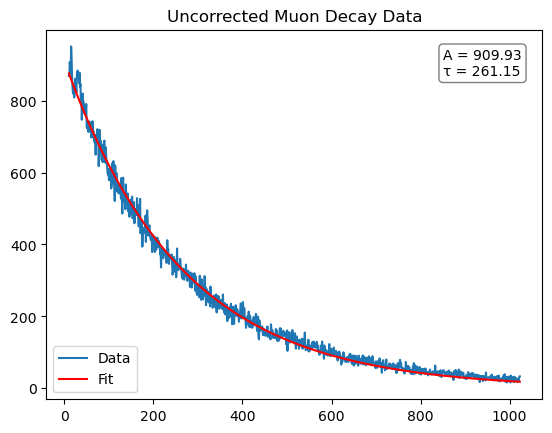

In [7]:
df = dl.load_muon_decay_txt("../Databases/muon_decay_combined_2025.txt")
display(df)
times = df.index.values 
counts = df['count'].values
popt, pcov = curve_fit(exponential_decay, times, counts, p0=(900, 1))
fit = exponential_decay(times, *popt)
plt.plot(times, counts, label='Data')
plt.plot(times, fit, label='Fit', color='red')
plt.legend()
plt.title("Uncorrected Muon Decay Data")

fit_params_text = f"A = {popt[0]:.2f}\nτ = {popt[1]:.2f}"
plt.text(0.8, 0.95, fit_params_text, transform=plt.gca().transAxes, fontsize=10,
    verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
